In [1]:
from sympy import var,Function,Symbol,Rational
from ComputabilityGraphs.CMTVS import CMTVS
from bgc_md2.helper import bgc_md2_computers
from bgc_md2.resolve.mvars import (
    InFluxesBySymbol,
    OutFluxesBySymbol,
    InternalFluxesBySymbol,
    TimeSymbol,
    StateVariableTuple,
)

In [2]:
# obtain dictionary of symbols for equations from txt file
params_in = open(r"mini_model_sym_dict.txt", 'r')
sym_dict = {}
for line in params_in:
    k, v = line.strip().split('=')
    sym_dict[k.strip()] = v.strip()
    
params_in.close()

In [3]:
#define all the symbols you are going to use in the equations

for k in sym_dict.keys():
    code=k+" = Symbol('{0}')".format(k)
    exec(code)
    
func_dict = {
    "Gpp_grass": "Total C production for grass in g/m^2*month FIXME"
}
for k in func_dict.keys():
    code=k+" = Function('{0}')".format(k)
    exec(code)    
    
#I_wood=Function("I_wood") 
t=TimeSymbol("t") # the symbol used for time since it has a special role
e = Symbol("e")   # for exponential functions

agprod = prdx_1*f_stemp_ppdf_1*((avh2o_1 + (ppt_m * 0.1)) / pet)*biof*shdmod*sdlng
bgprod = agprod * rtsh
cprodc = (agprod + bgprod) * 0.4
cprodf = ((prdx_2*f_stemp_ppdf_2*((avh2o_2 + (ppt_m * 0.1)) / pet)*f_lait_laitop*0.5) - sumrsp)


# formulate the model
mvs = CMTVS(
    {
        StateVariableTuple( # the pool names in your preferred order
            (
                AGLIVC,
                BGLIVC,
                STDEDC,
                STRUCC_1,
                STRUCC_2,
                SOM1C_1,
                SOM1C_2,
                SOM2C,
                SOM3C,
                METABC_1,
                METABC_2,
                CROOTC,
                FBRCHC,
                FROOTC,
                RLEAVC,
                RLWODC,
                WOOD1C,
                WOOD2C,
                WOOD3C,
            )
        ), 
        t, 
        InFluxesBySymbol({   # trees.F, growth.F
                AGLIVC: cprodc * (agprod/(agprod + bgprod)),
                BGLIVC: cprodc * (1 - (agprod/(agprod + bgprod))),
                RLEAVC: cprodf * fcfrac_1_1,
                FROOTC: cprodf * fcfrac_2_1,
                FBRCHC: cprodf * fcfrac_3_1,
                RLWODC: cprodf * fcfrac_4_1,
                CROOTC: cprodf * fcfrac_5_1
        }),
        OutFluxesBySymbol({    # CO2 losses
            # woodec.F DECW* and WDLIG* values at cen_warmstart.F PLIGST(*)=3
            WOOD1C: ((decw1 * defac * (e**(-3*wdlig_3)) * Rational(45,100) * (1-wdlig_3)) + \
                    (decw1 * defac * (e**(-3*wdlig_3)) * Rational(3,10) * wdlig_3)) * WOOD1C,
            WOOD2C: ((decw2 * defac * (e**(-3*wdlig_4)) * Rational(45,100) * (1-wdlig_4)) + \
                    (decw2 * defac * (e**(-3*wdlig_4)) * Rational(3,10) * wdlig_4)) * WOOD2C,
            WOOD3C: ((decw3 * defac * (e**(-3*wdlig_5)) * Rational(45,100) * (1-wdlig_5)) + \
                    (decw3 * defac * (e**(-3*wdlig_5)) * Rational(3,10) * wdlig_5)) * WOOD3C,
            # litdec.F declig.F somdec.F strlig(*)=ligcon PLIGST(*)=3 anerb=1; dec* have defined values in .100 files
            STRUCC_1: ((dec1_1 * defac * (e**(-3*strlig_1)) * Rational(3,10) * strlig_1) + \
                      (dec1_1 * defac * (e**(-3*strlig_1)) * Rational(45,100) * (1-strlig_1))) * STRUCC_1,  
            STRUCC_2: ((dec1_2 * defac * (e**(-3*strlig_2)) * Rational(3,10) * strlig_2) +  \
                      (dec1_2 * defac * (e**(-3*strlig_2)) * Rational(55,100) * (1-strlig_2))) * STRUCC_2, 
            METABC_1: (dec2_1 * defac * Rational(55,100)) * METABC_1, 
            METABC_2: (dec2_2 * defac * Rational(55,100)) * METABC_2,  
            SOM1C_1: (dec3_1 * defac * Rational(6,10)) * SOM1C_1,
            # eftext=peftxa*peftxb*sand prelim.F ln 304 PEFTXA, PEFTXB at .100
            SOM1C_2: (dec3_2 * defac * eftext * p1co2_2) * SOM1C_2,
            SOM2C: (dec5 * defac * Rational(55,100)) * SOM2C,
            SOM3C: (dec4 * defac * Rational(55,100)) * SOM3C
        }),
        InternalFluxesBySymbol({
            (AGLIVC, STDEDC): (fsdeth_i * dthppt + fsdeth_s) * AGLIVC,
            # NOTA BENE: STDEDC and BGLIVC to metabolic and structural pools include the lignin to N ratio,
            # which includes the N:C ratio. bglivc_1 = BGLIVC and stdedc_1 = STDEDC; N:C ratio may
            # need its own matrix.
            (BGLIVC, METABC_2): rdr * (1 - (avh2o_1/(deck5 + avh2o_1))) * \
            (spl_I - spl_S * (((fligni1_2 + fligni2_2*arain) * 2.5) / (bglive_1/bglivc_1)) ) * BGLIVC,
            (BGLIVC, STRUCC_2):  rdr * (1 - (avh2o_1/(deck5 + avh2o_1))) * \
            (1 - (spl_I - spl_S * (((fligni1_2 + fligni2_2*arain) * 2.5) / (bglive_1/bglivc_1)))) * BGLIVC,
            (STDEDC, METABC_1): fallrt * (spl_I - spl_S * (((fligni1_1 + fligni2_1*arain) * 2.5) / \
                                                           (stdede_1/stdedc_1)) ) * STDEDC,
            (STDEDC, STRUCC_1): fallrt * (1 - (spl_I - spl_S * (((fligni1_1 + fligni2_1*arain) * 2.5) / \
                                                                (stdede_1/stdedc_1)))) * STDEDC,
            # (1) leaves (2) fine roots (3) fine branches (4) large wood (5) coarse roots
            # wdeath.F WOODDR*, LEAFDR values at cen_warmstart.F
            # for RLEAVC, leafdr_d_mo=1 for tave less than 13C.
            # NOTA BENE: RLEAVC and FROOTC to metabolic and structural pools include the lignin to N ratio,
            # which includes the N:C ratio. rleavc_1 = RLEAVC and frootc_1 = FROOTC; N:C ratio may 
            # need its own matrix. 
            (RLEAVC, METABC_1): (wooddr_1 * leafdr_d_mo + (1-wooddr_1) * leafdr_e_mo) * \
            (spl_I - spl_S * ((wdlig_1 * 2.5) / (0.55 * rleave_1/rleavc_1)) ) * RLEAVC,
            (RLEAVC, STRUCC_1): (wooddr_1 * leafdr_d_mo + (1-wooddr_1) * leafdr_e_mo) * \
            ( 1 - (spl_I - spl_S * ((wdlig_1 * 2.5) / (0.55 * rleave_1/rleavc_1)) )) * RLEAVC,
            (FROOTC, METABC_2): wooddr_2 * (spl_I - spl_S * ((wdlig_2 * 2.5) / (froote_1/frootc_1)) ) * FROOTC,
            (FROOTC, STRUCC_2): wooddr_2 * ( 1 - (spl_I - spl_S * ((wdlig_2 * 2.5) / (froote_1/frootc_1)))) * FROOTC,
            (FBRCHC, WOOD1C): wooddr_3 * FBRCHC,
            (RLWODC, WOOD2C): wooddr_4 * RLWODC,
            (CROOTC, WOOD3C): wooddr_5 * CROOTC,
            (WOOD1C, SOM1C_2): (decw1 * defac * (e**(-3*wdlig_3)) * Rational(55,100) * (1-wdlig_3)) * WOOD1C,
            (WOOD1C, SOM2C): (decw1 * defac * (e**(-3*wdlig_3)) * Rational(7,10) * wdlig_3) * WOOD1C,
            (WOOD2C, SOM1C_2): (decw2 * defac * (e**(-3*wdlig_4)) * Rational(55,100) * (1-wdlig_4)) * WOOD2C,
            (WOOD2C, SOM2C): (decw2 * defac * (e**(-3*wdlig_4)) * Rational(7,10) * wdlig_4) * WOOD2C,
            (WOOD3C, SOM1C_2): (decw3 * defac * (e**(-3*wdlig_5)) * Rational(55,100) * (1-wdlig_5)) * WOOD3C,
            (WOOD3C, SOM2C): (decw3 * defac * (e**(-3*wdlig_5)) * Rational(7,10) * wdlig_5) * WOOD3C,
            (STRUCC_1, SOM1C_1): (dec1_1 * defac * (e**(-3*strlig_1)) * Rational(55,100) * (1-strlig_1)) * STRUCC_1,
            (STRUCC_1, SOM2C): (dec1_1 * defac * (e**(-3*strlig_1)) * Rational(7,10) * strlig_1) * STRUCC_1, 
            (STRUCC_2, SOM1C_2): (dec1_2 * defac * (e**(-3*strlig_2)) * Rational(45,100) * (1-strlig_2)) * STRUCC_2,
            (STRUCC_2, SOM2C): (dec1_2 * defac * (e**(-3*strlig_2)) * Rational(7,10) * strlig_2) * STRUCC_2, 
            (METABC_1, SOM1C_1): (dec2_1 * defac * Rational(45,100)) * METABC_1, 
            (METABC_2, SOM1C_2): (dec2_2 * defac * Rational(45,100)) * METABC_2, 
            (SOM1C_1, SOM2C): (dec3_1 * defac * Rational(4,10)) * SOM1C_1, # P1CO2A(1)=0.6
            # p1co2_2=p1co2a_2+p1co2b_2*sand prelim.F ln 311 P1CO2A(2), P1CO2B(2) at *.100
            # fps1s3=ps1s3(1)+ps1s3(2)*clay prelim.F ln 315 PS1S3(1), PS1S3(2) at *.100
            # orglch=omlech(1)+omlech(2)*sand predec.F ln 106 OMLECH(1), OMLECH(2) at *.100
            # f_asmos2=min(1-((omlech(3)-amov(2))/omlech(3)), 1) OMLECH(3) at *.100 amov(2) at h2olos.F
            (SOM1C_2, SOM2C): (dec3_2 * defac * eftext * (1 - p1co2_2 - fps1s3 - (orglch*f_asmos2))) * SOM1C_2, 
            (SOM1C_2, SOM3C): (dec3_2 * defac * eftext * fps1s3) * SOM1C_2, 
            (SOM2C, SOM1C_2): (dec5 * defac * fps2s3) * SOM2C, 
            # fps2s3=ps2s3(1)+ps2s3(2)*clay prelim.F ln 316 PS2S3(1), PS2S3(2) at *.100
            (SOM2C, SOM3C): (dec5 * defac * (Rational(45,100) - fps2s3)) * SOM2C, 
            (SOM3C, SOM1C_2): (dec4 * defac * Rational(45,100)) * SOM3C 
        }),
    },
    bgc_md2_computers()

)

In [4]:
#start to query the model description..
M=mvs.get_CompartmentalMatrix()
#M.inverse_LU()

In [5]:
mvs.get_InputTuple()

Matrix([
[       biof*f_stemp_ppdf_1*prdx_1*sdlng*shdmod*(avh2o_1 + 0.1*ppt_m)*(0.4*biof*f_stemp_ppdf_1*prdx_1*rtsh*sdlng*shdmod*(avh2o_1 + 0.1*ppt_m)/pet + 0.4*biof*f_stemp_ppdf_1*prdx_1*sdlng*shdmod*(avh2o_1 + 0.1*ppt_m)/pet)/(pet*(biof*f_stemp_ppdf_1*prdx_1*rtsh*sdlng*shdmod*(avh2o_1 + 0.1*ppt_m)/pet + biof*f_stemp_ppdf_1*prdx_1*sdlng*shdmod*(avh2o_1 + 0.1*ppt_m)/pet))],
[(0.4*biof*f_stemp_ppdf_1*prdx_1*rtsh*sdlng*shdmod*(avh2o_1 + 0.1*ppt_m)/pet + 0.4*biof*f_stemp_ppdf_1*prdx_1*sdlng*shdmod*(avh2o_1 + 0.1*ppt_m)/pet)*(-biof*f_stemp_ppdf_1*prdx_1*sdlng*shdmod*(avh2o_1 + 0.1*ppt_m)/(pet*(biof*f_stemp_ppdf_1*prdx_1*rtsh*sdlng*shdmod*(avh2o_1 + 0.1*ppt_m)/pet + biof*f_stemp_ppdf_1*prdx_1*sdlng*shdmod*(avh2o_1 + 0.1*ppt_m)/pet)) + 1)],
[                                                                                                                                                                                                                                                              

In [6]:
mvs.get_StateVariableTuple()

Matrix([
[  AGLIVC],
[  BGLIVC],
[  STDEDC],
[STRUCC_1],
[STRUCC_2],
[ SOM1C_1],
[ SOM1C_2],
[   SOM2C],
[   SOM3C],
[METABC_1],
[METABC_2],
[  CROOTC],
[  FBRCHC],
[  FROOTC],
[  RLEAVC],
[  RLWODC],
[  WOOD1C],
[  WOOD2C],
[  WOOD3C]])

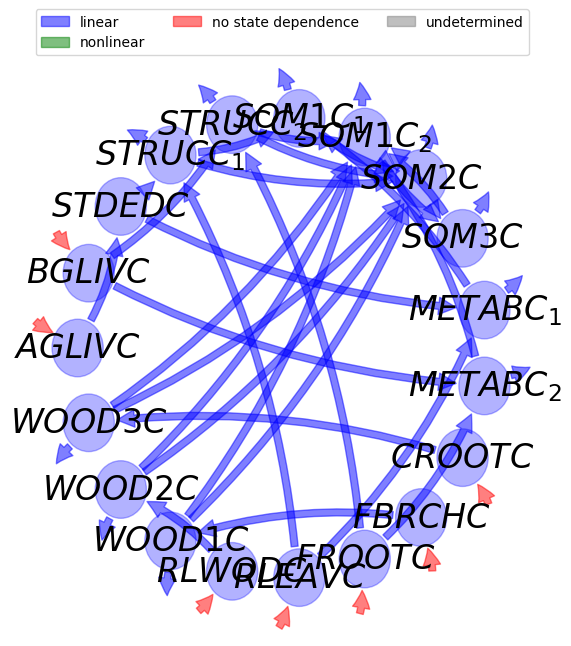

In [7]:
from bgc_md2.helper import compartmental_graph
compartmental_graph(mvs)

In [8]:
from bgc_md2.display_helpers import mass_balance_equation
mass_balance_equation(mvs)

<IPython.core.display.Math object>

In [9]:
# for comparison the century model as found in our database
from bgc_md2.models.Parton1987SoilSciSocAmJ.source_by_name import mvs as mvs_century

In [10]:
mvs.computable_mvar_types

<bound method CMTVS.computable_mvar_types of CMTVS({InternalFluxesBySymbol = InternalFluxesBySymbol({(AGLIVC, STDEDC): AGLIVC*(dthppt*fsdeth_i + fsdeth_s), (BGLIVC, METABC_2): BGLIVC*rdr*(-avh2o_1/(avh2o_1 + deck5) + 1)*(-bglivc_1*spl_S*(2.5*arain*fligni2_2 + 2.5*fligni1_2)/bglive_1 + spl_I), (BGLIVC, STRUCC_2): BGLIVC*rdr*(-avh2o_1/(avh2o_1 + deck5) + 1)*(bglivc_1*spl_S*(2.5*arain*fligni2_2 + 2.5*fligni1_2)/bglive_1 - spl_I + 1), (STDEDC, METABC_1): STDEDC*fallrt*(spl_I - spl_S*stdedc_1*(2.5*arain*fligni2_1 + 2.5*fligni1_1)/stdede_1), (STDEDC, STRUCC_1): STDEDC*fallrt*(-spl_I + spl_S*stdedc_1*(2.5*arain*fligni2_1 + 2.5*fligni1_1)/stdede_1 + 1), (RLEAVC, METABC_1): RLEAVC*(leafdr_d_mo*wooddr_1 + leafdr_e_mo*(1 - wooddr_1))*(-4.54545454545454*rleavc_1*spl_S*wdlig_1/rleave_1 + spl_I), (RLEAVC, STRUCC_1): RLEAVC*(leafdr_d_mo*wooddr_1 + leafdr_e_mo*(1 - wooddr_1))*(4.54545454545454*rleavc_1*spl_S*wdlig_1/rleave_1 - spl_I + 1), (FROOTC, METABC_2): FROOTC*wooddr_2*(-2.5*frootc_1*spl_S*wdlig_

In [19]:
mvs_century.get_InputTuple()

Matrix([
[J_surf*(0.018*LN + 0.15)],
[J_surf*(0.85 - 0.018*LN)],
[J_soil*(0.018*LN + 0.15)],
[J_soil*(0.85 - 0.018*LN)],
[                       0],
[                       0],
[                       0]])

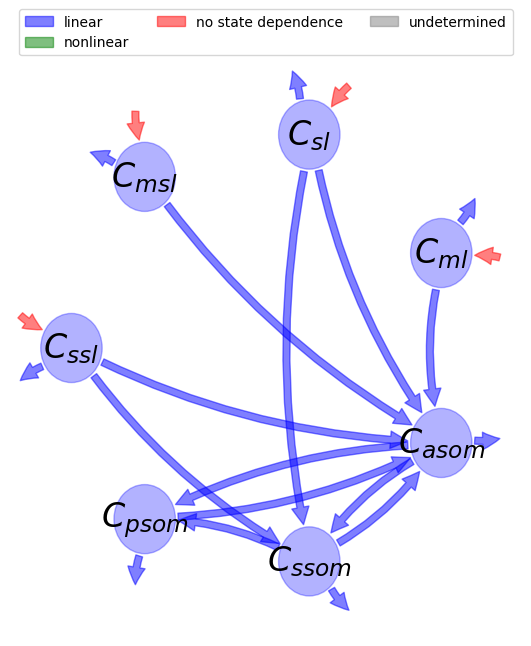

In [12]:
compartmental_graph(mvs_century)

In [13]:
mass_balance_equation(mvs_century)

<IPython.core.display.Math object>

In [14]:
BI=mvs_century.get_BibInfo()
BI.sym_dict

{'C_ssl': 'structural soil surface litter pool',
 'C_msl': 'metabolic soil surface litter pool',
 'C_sl': 'structural soil litter pool',
 'C_ml': 'metabolic soil litter pool',
 'C_asom': 'active soil organic matter pool',
 'C_ssom': 'slow soil organic matter pool',
 'C_psom': 'passive soil organic matter pool',
 'K_ssl': 'maximum decomposition rate of structural soil surface litter',
 'K_msl': 'maximum decomposition rate of metabolic soil surface litter',
 'K_sl': 'maximum decomposition rate of structural soil litter',
 'K_ml': 'maximum decomposition rate of metabolic soil litter',
 'K_asom': 'maximum decomposition rate of active soil organic matter',
 'K_ssom': 'maximum decomposition rate of slow soil organic matter',
 'K_psom': 'maximum decomposition rate of passive organic matter',
 'k_ssl': 'decomposition rate of structural soil surface litter',
 'k_sl': 'decomposition rate of structural soil litter',
 'k_asom': 'decomposition rate of active soil organic matter',
 'LN': 'lignin-to-

In [15]:
x=Symbol("x")

In [16]:
s=x**2-x

s

x**2 - x

In [17]:
type(s)

sympy.core.add.Add

In [18]:
from sympy import Rational
Rational(45,100)

9/20